# Assignment 4
## Business understanding
In this report we're trying to get insight into what contributes to housing prices. We will be trying to determine how a house's location(excact location and distance to relevant locations) and age affects housing prices.

## Data understanding
We're using a dataset from [https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set). It's a set that includes housing data from Sindian dist., New Taipei City, Taiwan.

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [122]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
  
# data (as pandas dataframes) 
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 

In [59]:
X.head(10)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores
0,2012.917,32.0,84.87882,10
1,2012.917,19.5,306.59470,9
2,2013.583,13.3,561.98450,5
3,2013.500,13.3,561.98450,5
4,2012.833,5.0,390.56840,5
5,2012.667,7.1,2175.03000,3
6,2012.667,34.5,623.47310,7
7,2013.417,20.3,287.60250,6
8,2013.500,31.7,5512.03800,1
9,2013.417,17.9,1783.18000,3


The data includes prameters for:
* Transaction date(years already as a continuous value)
* House age(years)
* Distance to nearest mass rapid transit(meters)
* Number of convenience stores withing walking distance(count)
* Coordinates (latitude and longitude separately)

The target value is in the unit of 10000 New Taiwan Dollar/Ping, where 1 Ping = 3.3 meter<sup>2</sup>  
There does not appear to be any missing or nonsensical values in the dataset

## Data preparation
Standardize the data values to estimate feature importance and for logistic regression performance. 
Latitude and longitude were removed from the data set to make the model more univeralized, as these location-specific variables would be useless outside the specific district where the data was collected.
Split the data into a training set(85%) and a test set(15%).

In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
#drop coordinate-data
X = X.drop(columns= ['X5 latitude', 'X6 longitude'])

#Standardization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#split for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=254)


## Linear regression
### Modeling

In [66]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
b0 = model.intercept_ 
b1 = model.coef_ 
print("Intercept: %.2f" % b0[0])
print("Coefficients:")
for name, coef in zip(X_train.columns, b1[0]):
    print(f"{name}: {coef:.4f}")

Intercept: 38.15
Coefficients:
X1 transaction date: 1.5407
X2 house age: -2.5901
X3 distance to the nearest MRT station: -6.4284
X4 number of convenience stores: 4.2962


In [67]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_test)

print("Mean absolute error: %.2f" % mean_absolute_error(y_test, preds))

Mean absolute error: 7.06


In [92]:
print("mean: " + y.values.mean().astype(str))
print("min: " + y.values.min().astype(str))
print("max: " + y.values.max().astype(str))
print("std: " + y.values.std().astype(str))

mean: 37.980193236714975
min: 7.6
max: 117.5
std: 13.590044806293161


The linear regression model, trained on the selected features, achieves a mean absolute error (MAE) of 7.06.

### Evaluation
From the linear regression model some conclusions can be drawn:  
From the coefficients  
X1 transaction date: 1.5407  
X2 house age: -2.5901  
X3 distance to the nearest MRT station: -6.4284  
X4 number of convenience stores: 4.2962  

It can be estimated that distance from mass transit and number of nearby convenience stores affects house prices the most from the used features.  

## Logistic Regression
### Modeling
For the logistic regression the target data must be transformed to binary form. Targets over the mean were converted to 1 and targets under to 0.

In [119]:
#all the data are already standardized
from sklearn.linear_model import LogisticRegression

#set targets > mean to 1 and < mean to 0
threshold = y.values.mean()
y_train_bin = (y_train > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)


reg = LogisticRegression(solver='lbfgs')
reg.fit(X_train,y_train_bin.values.ravel())
print("Coefficients: ",reg.coef_)
print("Intercept: ", reg.intercept_)

Coefficients:  [[ 0.24030673 -0.48945356 -2.39595461  0.64697425]]
Intercept:  [-0.36776608]


Accuracy: 0.83


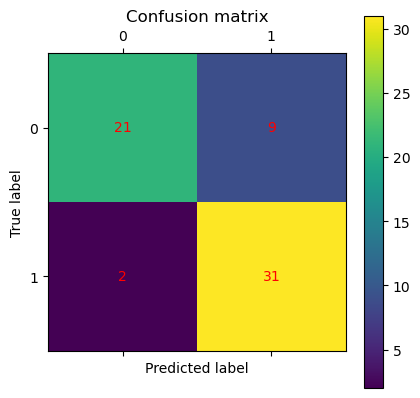

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_bin = reg.predict(X_test)

accuracy = accuracy_score(y_test_bin, y_pred_bin)

print("Accuracy: %0.2f" % accuracy)

cm = confusion_matrix(y_test_bin, y_pred_bin)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### Evaluation
The logistic regression gets an accuracy score of 0.83.  

Below we'll look at feature importance by using permutation importance

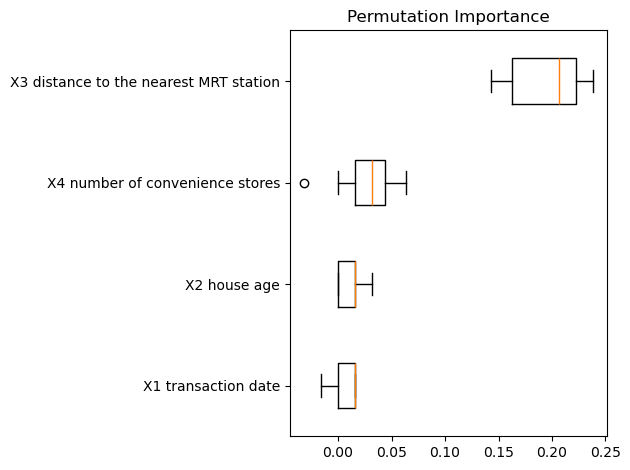

In [123]:
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X_test, y_test_bin, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

From the permutation importance we see that the importance of the distance to the nearest mass rapid transit is very high when categorizing the data to high and low cost housing. We also see that the date of the transaction affected it very little.

## Deployment
The linear regression model could be used to get a rough idea of housing price with any given inputs.  
Probably the most useful part of this model is the knowledge that there's a high correlation between housing prices and distance to mass transit and number of nearby convenience stores.  

To improve this model it would be really important to get data from other cities, countries or continents to test to see whether the conclusions are  really universalizeable.